In [7]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import time

class BatchSampler(object):
    '''
    A (very) simple wrapper to randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def random_batch_indices(self, m=None):
        if m is None:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.random.choice(self.indices, m, replace=False)
        return indices 

    def get_batch(self, m=None):
        '''
        Get a random batch without replacement from the dataset.
        If m is given the batch will be of size m. 
        Otherwise will default to the class initialized value.
        '''
        indices = self.random_batch_indices(m)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch  

In [8]:
def plotFig(_num, _dim, y , addInfo, title="default", xLabel="xlabel", yLabel="yLabel", plotLabel ="plotLabel" ):
    x = np.linspace(0, _dim, num=_dim)
   
    
    y = np.array(y)
    print(y.shape)
    plt.figure(_num)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    for i in range(y.shape[0]):
        plt.plot(x, y[i], label = plotLabel + str(addInfo[i]))
        
    plt.legend()
    plt.savefig( title + str(_num) + ".png")
    plt.close()
    plt.clf()
    

Data binary class Loaded
-------------------------------
(3500, 28, 28)
(100, 28, 28)
(145, 28, 28)
****** START Q1.1 *****
regTerm Tensor("Mul_1:0", shape=(), dtype=float32)
crossEntropyErrorCurr Tensor("Add:0", shape=(), dtype=float32)
learningrate =  0.005
current err 0.728765
epoch  0.0
current err 0.533234
epoch  1.0
regTerm Tensor("Mul_1:0", shape=(), dtype=float32)
crossEntropyErrorCurr Tensor("Add:0", shape=(), dtype=float32)
learningrate =  0.001
current err 0.782692
epoch  0.0
current err 0.555921
epoch  1.0
regTerm Tensor("Mul_1:0", shape=(), dtype=float32)
crossEntropyErrorCurr Tensor("Add:0", shape=(), dtype=float32)
learningrate =  0.0001
current err 0.787484
epoch  0.0
current err 0.659586
epoch  1.0
train done
(3, 5000)
(3, 5000)


ValueError: setting an array element with a sequence.

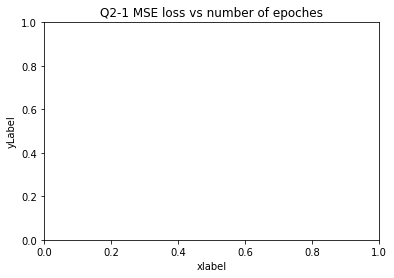

In [9]:
def loadBinData():
# import binary NOTMIST data set
    with np.load("notMNIST.npz") as data :
        Data, Target = data ["images"], data["labels"]
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
        
    print("Data binary class Loaded")
    print("-------------------------------")
    return trainData, trainTarget,validData, validTarget,\
        testData, testTarget

def linearMSE(y_hat, target):
    '''
    TODO: the MSE calculation
    '''
    #print("y_hat",  y_hat)
    
    se_mat = tf.square(tf.subtract(y_hat, target))
    #print("msemst", mse_mat)
    mse_mat = tf.reduce_mean(se_mat)
    loss = tf.reduce_mean(mse_mat)
    loss = tf.div(loss, tf.constant(2.0))

    return loss    
    

def arrFlatten(arr):
    
    print(arr.shape)

    dataDim1, dum1, dum2 = arr.shape
    arr = np.reshape(arr, [ dataDim1 ,784 ])
    return arr



def logisticBuildGraph(_regLambda, _learningRate, gd):
    '''
    Input: _data is x in the equation, dim by 784 flattened tensor
       _target is y in the equaion
       _regLambda is the wegithed decay coeff
       _learningRate is the epsilon
    '''

    #declare using a placeholder, feed in _data and _target to x ,y 
    #x_dim, dum1 =_data.get_shape().as_list()
    X = tf.placeholder(tf.float32, shape=[None, 784], name='dataX')
    # W initialize to a gaussian distr, honestly anything would work
    W = tf.Variable(tf.truncated_normal(shape=[784, 1], stddev=0.1), name='weights')
    W = tf.cast(W, dtype=tf.float32)
    b = tf.Variable(0.0, name='biases')
    y_target = tf.placeholder(tf.float32, shape=[None, 1], name='targetY')
    
    #compute the current y_hat
    wtxb =  tf.matmul(X, W) + b
    y_hat = tf.sigmoid(wtxb)
    #compute the current loss
    crossEntropyErrorCurr = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_target, logits= y_hat))

    #compute the decay/regularization term
    regTerm = tf.multiply( 0.50, tf.multiply(_regLambda, tf.reduce_mean(tf.square(W))))
    print("regTerm", regTerm)
    crossEntropyErrorCurr = tf.add(crossEntropyErrorCurr, regTerm)
    print("crossEntropyErrorCurr", crossEntropyErrorCurr)
    
    if gd == True:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = _learningRate)
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate = _learningRate)
    
    train = optimizer.minimize(loss=crossEntropyErrorCurr)

    return W, b, crossEntropyErrorCurr, y_hat, X, y_target, train


def runLogisticGraphPart1(trainData, trainTarget, validData, validTarget,testData, testTarget):
    '''
    Input: _data,
           _target,
           _numIters
    Output:
           required accuracy/epoch plots
           
    '''
    
    regLambda = 0.01
    learningRateArr = [0.005, 0.001, 0.0001]
    numIter = 5000
    numEpoch =int(np.ceil(20000/7))
    batchSize = 500
    epochTrainSize = 3500 #for training data
    trainLossAll = []
    mseLossAll = []
    
    for learningRate in learningRateArr:
        trainLossLR = []
        mseLossLR = []
        tf.reset_default_graph()
        W, b, crossEntropyErrorCurr, y_hat, X, y_target, train = logisticBuildGraph(regLambda, learningRate, True)
    

        init = tf.global_variables_initializer()
        sess = tf.InteractiveSession()
        sess.run(init)
        initialW = sess.run(W)  
        initialb = sess.run(b)            
        #training model and iter through batches
        print("learningrate = ", learningRate)
        
        for i in range(numIter):
            trainBatchSampler = BatchSampler(trainData, trainTarget, batchSize)
            dataBatch, targetBatch = trainBatchSampler.get_batch()
            #dataBatch = tf.stack(dataBatch)
            #targetBatch = tf.stack(targetBatch)
            currentW, currentb, errTrain, y_predict, trainModel = sess.run([W, b, crossEntropyErrorCurr, y_hat, train], feed_dict={X: dataBatch, y_target: targetBatch})
            trainLossLR.append(errTrain)
            mseLoss = linearMSE(y_predict, targetBatch)
            mseLossLR.append(mseLoss)
            
            if i%3500 == 0:
                print("current err", errTrain)
                print("epoch ", i/3500)
        
        trainLossAll.append(trainLossLR)
        mseLossAll.append(mseLossLR)
        
    print("train done")
    plotFig(1, numIter, trainLossAll, learningRateArr,  title = "Q2-1 logistic loss vs number of epoches",\
            plotLabel="learning rate")
    
    plotFig(1, numIter, mseLossAll, learningRateArr,  title = "Q2-1 MSE loss vs number of epoches",\
            plotLabel="learning rate")


    
def runLogisticGraphPart2(trainData, trainTarget):
    regLambda = 0.01
    learningRate = 0.001
    learningRateArr = [0.001]
    numIter = 5000
    numEpoch =int(np.ceil(20000/7))
    batchSize = 500
    epochTrainSize = 3500 #for training data
    trainLossAll = []
    
    
   
    trainLossLR = []
    tf.reset_default_graph()
    W, b, crossEntropyErrorCurr, y_hat, X, y_target, train = logisticBuildGraph(regLambda, learningRate, False)
    

    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    initialW = sess.run(W)  
    initialb = sess.run(b)            
    #training model and iter through batches
    print("learningrate = ", learningRate)
        
    for i in range(numIter):
        trainBatchSampler = BatchSampler(trainData, trainTarget, batchSize)
        dataBatch, targetBatch = trainBatchSampler.get_batch()
        #dataBatch = tf.stack(dataBatch)
        #targetBatch = tf.stack(targetBatch)
        currentW, currentb, errTrain, y_predict, trainModel = sess.run([W, b, crossEntropyErrorCurr, y_hat, train], feed_dict={X: dataBatch, y_target: targetBatch})
        trainLossLR.append(errTrain)
        if i%3500 == 0:
            print("current err", errTrain)
            print("epoch ", i/3500)
        
    trainLossAll.append(trainLossLR)
    
    print("train done")
    plotFig(1, numIter, trainLossAll, learningRateArr,  title = "q2-2 logistic loss vs number of epoches",\
            plotLabel="learning rate")

    
     


if __name__ == '__main__':  
        

    #trainTarget = arrFlatten(trainTarget)
    trainData, trainTarget, validData, validTarget,testData, testTarget = loadBinData()
    #data is (3500, 28, 28)
    #the label [1] or [0] is stored in target
    trainData = arrFlatten(trainData)
    validData = arrFlatten(validData)
    testData = arrFlatten(testData)
    
    print("****** START Q1.1 *****")
    runLogisticGraphPart1(trainData, trainTarget, validData, validTarget,testData, testTarget)



    '''
       
    print("****** START Q1.2 *****")
    runLogisticGraphPart2(trainData, trainTarget)
    runLogisticGraphPart3(trainData, trainTarget, validData, validTarget,testData, testTarget )
    '''